# Image Recognition with Tensorflow 2

In the first session, we learned how to make a basic image recognition model in tensorflow, but our model performed rather poorly. 

Today, we'll be going over various ways to improve our model.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

2023-07-12 09:21:47.709963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We'll need to get our dataset again -> images of daisies, dandelions, roses, sunflowers, tulips.

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

We can then reload our model into Keras. 

In [4]:
# set batch size and image size
batch_size = 32
img_height = 180
img_width = 180

# load data set
# training split
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# validation split
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

# configure for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


2023-07-12 09:22:03.078995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Our first model was built by constructing various layers that feed into one another. The layers so far included:

- rescaling our values to be between 0 and 1, rather than 0 and 255.
- flattening our data to be in a single dimension, rather than 3.
- a fully connected Dense layer that uses all pixel information
- another fully connected layer that makes class predictions

We then compile our model and pick an optimizer, a loss function, and a measure for us to evaluate.

In [5]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 flatten (Flatten)           (None, 97200)             0         
                                                                 
 dense (Dense)               (None, 32)                3110432   
                                                                 
 dense_1 (Dense)             (None, 5)                 165       
                                                                 
Total params: 3,110,597
Trainable params: 3,110,597
Non-trainable params: 0
_________________________________________________________________


We then run our model for 10 epochs.

In [6]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 2s 8ms/step - loss: 3.0879 - accuracy: 0.2228 - val_loss: 1.5999 - val_accuracy: 0.2262
Epoch 2/10
92/92 [==============================] - 0s 5ms/step - loss: 1.5920 - accuracy: 0.2520 - val_loss: 1.6064 - val_accuracy: 0.2398
Epoch 3/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6047 - accuracy: 0.2459 - val_loss: 1.6050 - val_accuracy: 0.2398
Epoch 4/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6033 - accuracy: 0.2459 - val_loss: 1.6038 - val_accuracy: 0.2398
Epoch 5/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6022 - accuracy: 0.2459 - val_loss: 1.6029 - val_accuracy: 0.2398
Epoch 6/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6014 - accuracy: 0.2459 - val_loss: 1.6025 - val_accuracy: 0.2398
Epoch 7/10
92/92 [==============================] - 0s 4ms/step - loss: 1.6009 - accuracy: 0.2459 - val_loss: 1.6022 - val_accuracy: 0.2398
Epoch 8/10
92/92 [==

We then plotted the model, showing loss and accuracy over time as the model trained for the training and validation data. 

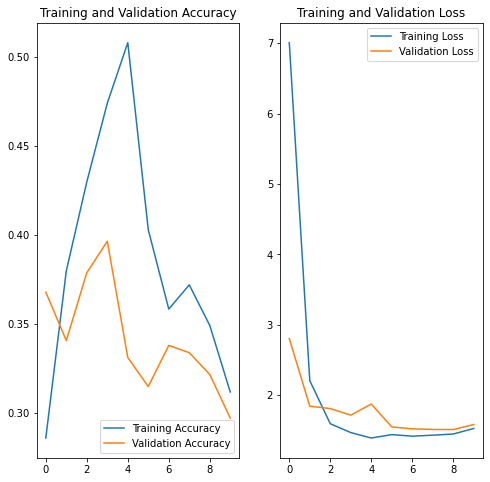

In [ ]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.ylim(0, 1)
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
plot_results(history)

## Model complexity

Our original model had 32 nodes in the primary Dense layer. We can increase the number of nodes to try to capture more complicated relationships in our image data.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 97200)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               12441728  
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 12,442,373
Trainable params: 12,442,373
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
92/92 [==============================] - 4s 43ms/step - loss: 11.6261 - accuracy: 0.3137 - val_loss: 4.4865 - val_accuracy: 0.3501
Epoch 2/10
92/92 [==============

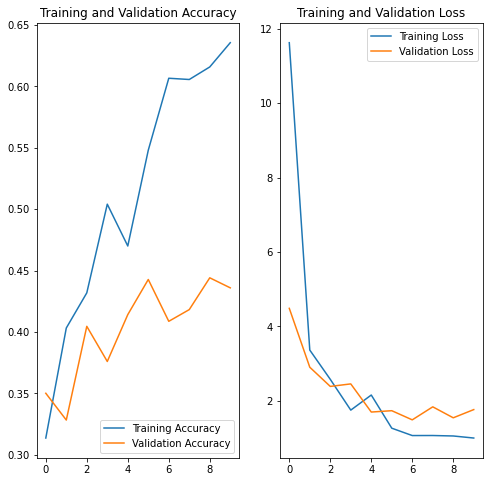

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

plot_results(history)

## Convolutional layer

Having more nodes helps, but our model performance is still poor. Dense layers ignore the dimensional and structural parts of a image -> which are the values of the pixels nearby?

To consider this dimensional aspect of image data, we need to add an additional layer called a **convolutional layer**. Convolutional layers look for patterns of pixels across small portions of our image, such as vertical or horizontal lines. These filters are passed over the image in an overlapping fashion to pick out where they occur.

![convolutional layer](https://docs-assets.developer.apple.com/published/09348c5368/a55b1477-4f79-4221-8aa1-ab3ae9f01f89.png)

We'll start by applying 16 filters to our 3 RGB channels. `padding=same` just makes sure the output for each filter is the same size as each image. We'll use the same activation function as for the Dense layer, as well. 

After the convolutional layer, we'll add a **max pooling layer**. Max pooling layers will summarize parts of the image for each filter, saying how strongly the filter appeared in each region of the image. 

![max pooling](https://production-media.paperswithcode.com/methods/MaxpoolSample2.png)

We'll also keep our Dense layer, and feed the output of the convolutional layer to it. 

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 flatten_2 (Flatten)         (None, 129600)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               16588928  
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                      

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 19s 205ms/step - loss: 2.7117 - accuracy: 0.3689 - val_loss: 1.2002 - val_accuracy: 0.5300
Epoch 2/10
92/92 [==============================] - 19s 203ms/step - loss: 1.0120 - accuracy: 0.6117 - val_loss: 1.1187 - val_accuracy: 0.5518
Epoch 3/10
92/92 [==============================] - 19s 201ms/step - loss: 0.6562 - accuracy: 0.7779 - val_loss: 1.1482 - val_accuracy: 0.5531
Epoch 4/10
92/92 [==============================] - 18s 198ms/step - loss: 0.3904 - accuracy: 0.8774 - val_loss: 1.1849 - val_accuracy: 0.5722
Epoch 5/10
92/92 [==============================] - 18s 199ms/step - loss: 0.2505 - accuracy: 0.9309 - val_loss: 1.2524 - val_accuracy: 0.5668
Epoch 6/10
92/92 [==============================] - 18s 198ms/step - loss: 0.1323 - accuracy: 0.9710 - val_loss: 1.2868 - val_accuracy: 0.5926
Epoch 7/10
92/92 [==============================] - 18s 198ms/step - loss: 0.0660 - accuracy: 0.9911 - val_loss: 1.3707 - val_accuracy: 0.5899

This model still performs less than optimally, but more consistently overall. 

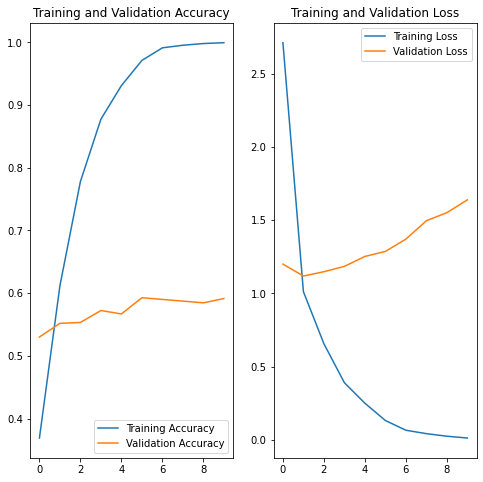

In [ ]:
plot_results(history)

## Adding more layers

A single convolutional layer can pick simple parts of images, like lines or curves. However, if we feed the output from one convolutional layer to a new convolutional layer, the model can start to identify pieces of the image together. Lines can combine to be the ovals, which can combine to be the petals of a flower by the time we reach a third layer. By looking at combinations of simple parts of an image, the model becomes capable of identifying complex components. 

We do want to add a max pooling layer after every convolutional layer to help summarize as our model grows increasingly complex.

![More layers](https://i0.wp.com/developersbreach.com/wp-content/uploads/2020/08/cnn_banner.png?fit=1200%2C564&ssl=1)

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 45, 45, 64)       

Fit same model as last time. 

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 27s 291ms/step - loss: 1.3183 - accuracy: 0.4261 - val_loss: 1.0591 - val_accuracy: 0.5831
Epoch 2/10
92/92 [==============================] - 26s 285ms/step - loss: 0.9913 - accuracy: 0.6161 - val_loss: 0.9428 - val_accuracy: 0.6349
Epoch 3/10
92/92 [==============================] - 26s 288ms/step - loss: 0.8171 - accuracy: 0.6890 - val_loss: 0.9348 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 27s 292ms/step - loss: 0.6254 - accuracy: 0.7677 - val_loss: 0.8966 - val_accuracy: 0.6689
Epoch 5/10
92/92 [==============================] - 28s 302ms/step - loss: 0.4223 - accuracy: 0.8525 - val_loss: 0.9658 - val_accuracy: 0.6499
Epoch 6/10
92/92 [==============================] - 27s 293ms/step - loss: 0.2534 - accuracy: 0.9094 - val_loss: 1.1513 - val_accuracy: 0.6540
Epoch 7/10
92/92 [==============================] - 27s 291ms/step - loss: 0.1246 - accuracy: 0.9612 - val_loss: 1.2691 - val_accuracy: 0.6553

Our model is starting to perform a lot better, with our validation accuracy above 60%. We can see that training accuracy is actually nearly perfect however, and our validation loss is actually becoming worse over time.

This pattern is consistent with **overfitting**. This occurs when the model becomes excellent at predicting the training data, but the predictions don't generalize as well to new data. 

You can think of overfitting as memorizing an answer sheet. When the model gets presented new information that is not on the answer sheet, it does poorly. 

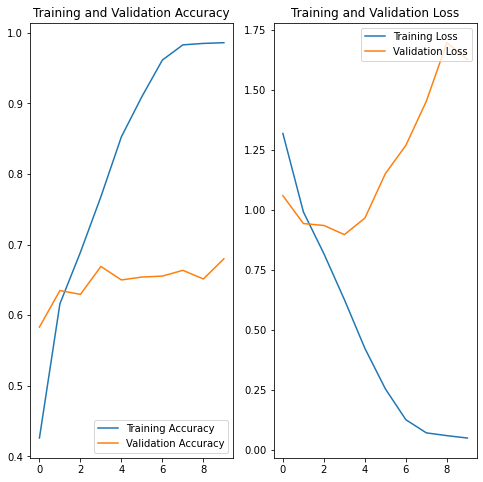

In [ ]:
plot_results(history)

## Dropout layer
Overfitting can be caused by having a model that is too complicated. New data are not likely to contain every single feature or shape in our training data, so making our model contain too many of these can lead to overfitting. 

To alleviate this problem, we can use a **dropout layer**. This randomly removes a proportion of the inputs to the next layer, removing some complexity from the model.

<img src='https://www.baeldung.com/wp-content/uploads/sites/4/2020/05/2-1-2048x745-1.jpg' width='50%'>

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 45, 45, 64)       

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 29s 307ms/step - loss: 1.3546 - accuracy: 0.4223 - val_loss: 1.1092 - val_accuracy: 0.5518
Epoch 2/10
92/92 [==============================] - 28s 309ms/step - loss: 1.0138 - accuracy: 0.5988 - val_loss: 1.0544 - val_accuracy: 0.5545
Epoch 3/10
92/92 [==============================] - 31s 334ms/step - loss: 0.8875 - accuracy: 0.6608 - val_loss: 0.9508 - val_accuracy: 0.6444
Epoch 4/10
92/92 [==============================] - 29s 320ms/step - loss: 0.7057 - accuracy: 0.7354 - val_loss: 0.8625 - val_accuracy: 0.6757
Epoch 5/10
92/92 [==============================] - 29s 315ms/step - loss: 0.5017 - accuracy: 0.8225 - val_loss: 1.0555 - val_accuracy: 0.6158
Epoch 6/10
92/92 [==============================] - 28s 306ms/step - loss: 0.3867 - accuracy: 0.8617 - val_loss: 1.1080 - val_accuracy: 0.6390
Epoch 7/10
92/92 [==============================] - 29s 311ms/step - loss: 0.2145 - accuracy: 0.9271 - val_loss: 1.3570 - val_accuracy: 0.6499

We can see that our model performance didn't really improve over the last rendition. Model performance is still plateauing, meaning reducing model complexity was not incredibly successful.

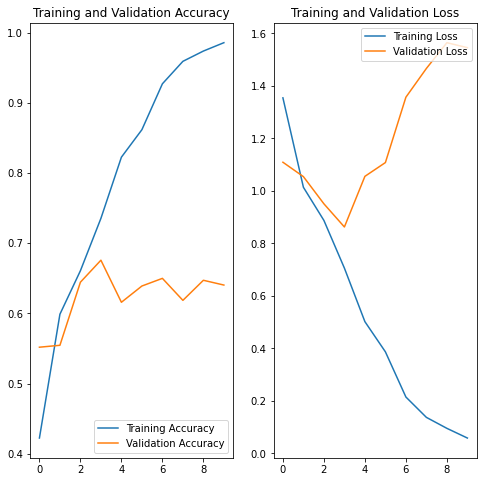

In [ ]:
plot_results(history)

## Data augmentation

Our data set is somewhat limited in size, only containing several thousand images. We could try to increase the sample size by grabbing more images of flowers from the internet, which can be time consuming.

Another potential solution is **data augmentation**. Data augmentation is taking the data we already have and applying random transformations to data to generate more training data. For us, this means taking images we already have, and randomly flipping rotating, and zooming them. We then add these modified images to the data set. 

Note: the current version of tensorflow prints out a lot of warnings when you do data augmentation. This is a bug which you can safely ignore. 

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

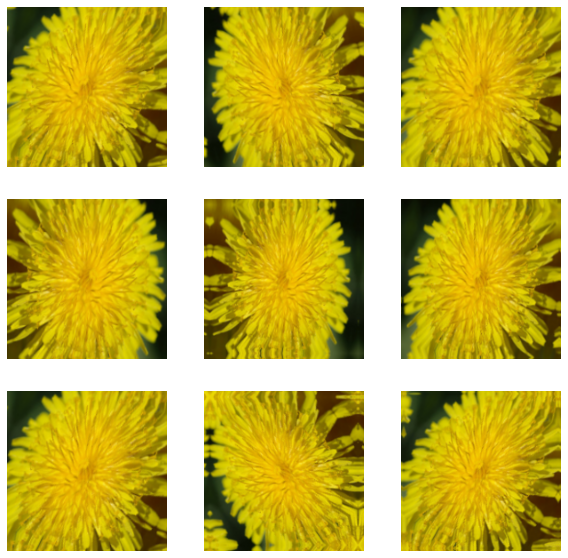

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

We can insert the data augmentation into the model as a first layer.

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_10 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

We increase the number of epochs here to make sure we minimize validation loss.

In [59]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 39s 397ms/step - loss: 1.5190 - accuracy: 0.3549 - val_loss: 1.2346 - val_accuracy: 0.5054
Epoch 2/15
92/92 [==============================] - 36s 384ms/step - loss: 1.1155 - accuracy: 0.5572 - val_loss: 1.0125 - val_accuracy: 0.5981
Epoch 3/15
92/92 [==============================] - 34s 366ms/step - loss: 0.9950 - accuracy: 0.6080 - val_loss: 1.0111 - val_accuracy: 0.6185
Epoch 4/15
92/92 [==============================] - 34s 372ms/step - loss: 0.9179 - accuracy: 0.6465 - val_loss: 0.8878 - val_accuracy: 0.6553
Epoch 5/15
92/92 [==============================] - 35s 384ms/step - loss: 0.8666 - accuracy: 0.6761 - val_loss: 0.8717 - val_accuracy: 0.6485
Epoch 6/15
92/92 [==============================] - 35s 384ms/step - loss: 0.7942 - accuracy: 0.7061 - val_loss: 0.9242 - val_accuracy: 0.6526
Epoch 7/15
92/92 [==============================] - 36s 386ms/step - loss: 0.7403 - accuracy: 0.7197 - val_loss: 0.8909 - val_accuracy: 0.6689

We are now approaching validation accuracy of 70%, much better than where we started. However, there is still room to improve. Feel free to keep trying to make modifications to make the model better.

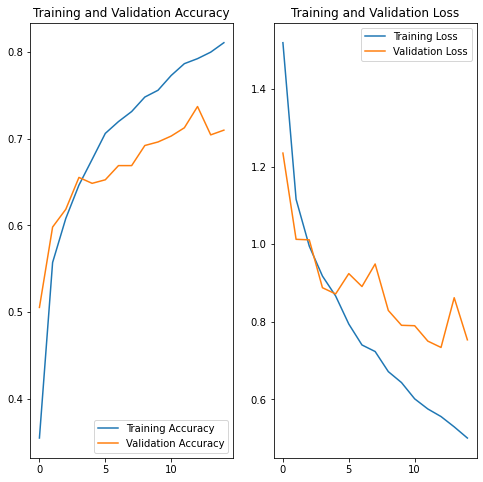

In [60]:
plot_results(history)

## Using our model to make predictions

We can try to predict flower type of an image not in the training or validation set. We have a function below that imports images of flowers from the internet (when provided a URL) and uses the model we've made to predict the flower type.  

In [65]:
def predict_flower(flower_url):
    
    flower_path = tf.keras.utils.get_file(origin=flower_url)

    img = tf.keras.utils.load_img(
        flower_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )
    
    return None

Our model makes some successful predictions with high confidence, but it also makes some incorrect predictions with reasonably high confidence as well.

In [83]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
tulip_url = "https://helloartsy.com/wp-content/uploads/kids/flowers/how_to_draw_a_tulip/how-to-draw-a-tulip_step-6.jpg"
dandelion_url1 = "https://cdn.shopify.com/s/files/1/0687/5634/1034/products/36077__95056__65448.1660005730.1280.1280_1280x.jpg"
dandelion_url2 = "https://www.minnesotawildflowers.info/udata/r9ndp23q/pd/taraxacum-officinale-3.jpg"
rose_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Natural_Rose_1.jpg/3024px-Natural_Rose_1.jpg"
daisy_url = "https://upload.wikimedia.org/wikipedia/commons/5/53/Belis_peremnis_-_panoramio.jpg"

print('SUNFLOWER')
predict_flower(sunflower_url)
print('TULIP')
predict_flower(tulip_url)
print('DANDELION (yellow)')
predict_flower(dandelion_url1)
print('DANDELION (white)')
predict_flower(dandelion_url2)
print('ROSE')
predict_flower(rose_url)
print('DAISY')
predict_flower(daisy_url)

SUNFLOWER
1/1 [==============================] - 0s 40ms/step
This image most likely belongs to sunflowers with a 96.83 percent confidence.
TULIP
1/1 [==============================] - 0s 25ms/step
This image most likely belongs to tulips with a 86.29 percent confidence.
DANDELION (yellow)
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to sunflowers with a 97.73 percent confidence.
DANDELION (white)
1/1 [==============================] - 0s 25ms/step
This image most likely belongs to dandelion with a 70.18 percent confidence.
ROSE
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to tulips with a 72.36 percent confidence.
DAISY
1/1 [==============================] - 0s 21ms/step
This image most likely belongs to daisy with a 99.99 percent confidence.
